# Figure 1

## Overview of the 1,010 High-Impact Precipitation Events (HIPEs) detected across the Alps for the period 1961–2022. 

In [11]:
## ---- Libraries and custom functions --------------------------------------
library(tidyverse)
library(terra)
library(tidyterra)
library(cptcity)
library(metR)
library(sf)
library(ggprism)
library(elevatr)
library(patchwork)
library(scales)
library(giscoR)
setwd("/mnt/CEPH_PROJECTS/HIPEAtMount/HIPEAtMount-WP1")
source("Script/Functions/theme_plot.R")
source("Script/Functions/Ranking_functions.R")
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 200)


In [12]:
## ---- Borders & geographic context ----------------------------------------
# Getting Alpine and neighboring borders
borders <- giscoR::gisco_get_countries(country = c(
  "Italy","Switzerland","France","Austria","Slovenia",
  "Germany","Croatia","Bosnia"
), resolution = "03")

world <- giscoR::gisco_coastallines

borders_w_nuts <- giscoR::gisco_get_nuts(year = 2021, resolution = "03", nuts_level = 0) %>%
    st_transform(crs = st_crs(borders))

# Alpine convention borders
borders_convention <- read_sf("Data/Borders/Alpine_Convention_Perimeter_2018_v2/Alpine_Convention_Perimeter_2018_v2.shp") %>%
  st_transform(crs = st_crs(borders)) %>%
  st_make_valid()



# HISTALP borders
HISTALP_borders <- read_sf("Data/Borders/Shape_CRSM/Shape_CRSM.shp") %>%
  st_transform(crs = st_crs(borders)) %>%
  st_make_valid()

# Intersecting HISTALP with Alpine convention borders
GAR_HISTALP_intersect <- st_intersection(borders_convention, HISTALP_borders) %>% 
  dplyr::select(Id.1) %>% 
  dplyr::rename(Regions = Id.1) %>%
  mutate(
    Regions = ifelse(Regions == 0, "Southwest", Regions),
    Regions = ifelse(Regions == 1, "Northwest", Regions),
    Regions = ifelse(Regions == 2, "Northeast", Regions),
    Regions = ifelse(Regions == 3, "Southeast", Regions)
  )

# River network in the Alpine convention
rivers <- rnaturalearth::ne_download(scale = 10, type = 'rivers_lake_centerlines', category = 'physical') %>%
  st_intersection(borders_convention)


Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
Reading ne_10m_rivers_lake_centerlines.zip from naturalearth...
Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


In [13]:
## ---- Preparing DEM to be aligned to the Alpine Combined Precitation Dataset (~8 km)-------------------------
sample <- rast("Data/ALPINE_COMB/ACPD_1961.nc")[[1]]
mdt <- get_elev_raster(GAR_borders, z = 5) %>% 
  rast() %>%
  terra::project(y = sample) %>%
  terra::crop(borders_convention) %>% 
  terra::mask(borders_convention)
mdtdf <- as.data.frame(mdt, xy = TRUE)
names(mdtdf)[3] <- "alt"

sample_4_extent <- rast("Data/APGD/harmonised/RapdD_al05_19710100_harm.nc")[[1]]
extent <- ext(sample_4_extent)


Mosaicing & Projecting

Note: Elevation units are in meters.



In [14]:
## ---- DEM map --------------------------------------------------------------
mdt_map <- ggplot() +
  geom_contour_fill(
    data = mdtdf,
    aes(x, y, z = alt)
  ) +
  geom_sf(data = GAR_HISTALP_intersect, fill = "transparent", color = "black") +
  geom_sf(data = rivers, color = "lightblue") +
  scale_fill_stepsn(colors = rev(grey.colors(100)),
                    breaks = c(0,200,500,1000,1500,2000,2500,3000,3500),
                    limits = c(0,3500)) +
  guides(fill = guide_colorsteps(
    barwidth = 5,
    barheight = .2,
    title.position = "top",
    frame.linewidth = 0.15,
    frame.colour = "black"
  )) +
  annotate("text", x = -Inf, y = Inf, label = "(b)",
           hjust = -0.5, vjust = 1.5, size = 2.8) +
  labs(fill = "m") +
  coord_sf() +
  theme_void() +
  theme(
    legend.position = "inside",
    legend.position.inside = c(0.65,.21),
    legend.direction = "horizontal",
    legend.title.position = "top",
    legend.text = element_text(angle = 90, size = 7),
    legend.title = element_text(angle = 0, hjust = 0.5, size = 7),
    legend.spacing.y = unit(0.05, "cm")
  )

In [15]:
# Load ranking ACPD-HIPEs --------------------------------------------------
ACPD_HIPE <- read_csv("Output/Data/2_ranking_databases/ACPD_complete_ranking/ACPD_HIPE_Ranking_1961-2022_multiday.csv") %>%
  mutate(dataset = "ACPD",
         id = 1:nrow(.)) 

ACPD_HIPE %>% head

Rows: 1010 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (6): Event, A, m, m_log, M, Duration
date (2): Start_date, End_date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Event,A,m,m_log,M,Start_date,End_date,Duration,dataset,id
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<date>,<dbl>,<chr>,<int>
937,0.10193898,65.70453,9.381368,0.9563271,2018-10-27,2018-10-29,3,ACPD,1
870,0.05025663,66.69736,12.917562,0.6491931,2014-11-02,2014-11-06,5,ACPD,2
622,0.05638723,111.58379,10.488301,0.5914062,2000-10-13,2000-10-15,3,ACPD,3
86,0.05218135,90.50554,11.317847,0.5905805,1966-11-02,1966-11-05,4,ACPD,4
812,0.06465640,65.77844,9.134043,0.5905743,2011-11-04,2011-11-06,3,ACPD,5
607,0.09869547,35.89621,5.877381,0.5800709,1999-09-19,1999-09-20,2,ACPD,6


In [16]:
## ---- Seasonal distribution (metrics) -------------------------------------
seasonalities_long <- ACPD_HIPE %>%
  mutate(season = season(Start_date)) %>%
  pivot_longer(cols = c(Duration, A, m, M), names_to = "metric", values_to = "value") %>%
  group_by(season, metric) %>%
  summarise(
    mx = max(value, na.rm = TRUE),
    min = min(value, na.rm = TRUE),
    q25 = quantile(value, 0.1, na.rm = TRUE),
    q75 = quantile(value, 0.9, na.rm = TRUE),
    med = median(value, na.rm = TRUE),
    mean = mean(value, na.rm = TRUE),
    n_events = n()  # Comptem els esdeveniments
  ) 

seasonalities_long_plot1<- seasonalities_long %>%
  filter(metric != "Duration") %>%
  mutate(metric_label = case_when(
    metric == "A" ~ "(d) ~A~' Area fraction'",
    metric == "m" ~ "(e) ~bar(m)~' Local magnitude'",
    metric == "M" ~ "(f) ~ M == log(bar(m) + 1) * A", # Updated equation
    # metric == "Duration" ~ "(d) ~Duration (days)"
  ))

g1 <- ggplot(seasonalities_long_plot1) +
  geom_crossbar(aes(x = season, y = 0, ymin = min, ymax = mx),
                fatten = 0, fill = "grey90", colour = NA) +
  geom_crossbar(aes(x = season, y = 0, ymin = q25, ymax = q75),
                fatten = 0, fill = "grey70") +
  geom_crossbar(aes(x = season, y = med, ymin = med, ymax = med),
                fatten = 2, colour = "black") +
  geom_point(aes(x = season, y = mean), 
             color = "darkred", size = 1) +
  scale_y_continuous(guide = guide_prism_minor(), breaks =  breaks_pretty(5) )+
  facet_wrap(~ metric_label, scales = "free_y", labeller = label_parsed,nrow = 1) +
  theme_4paper2 +
  theme(axis.title.y = element_blank(),
        axis.title.x = element_blank(),
        axis.ticks.y = element_line(),
        plot.background = element_rect(fill = "transparent"),
        panel.background = element_rect(fill = "white"))

seasonalities_long_plot2 <- seasonalities_long %>% filter(metric == "Duration") 


g2 <- ggplot(data = seasonalities_long_plot2) +
  geom_crossbar(aes(x = season, y = 1, ymin = min, ymax = mx),
                fatten = 0, fill = "grey90", colour = NA) +
  geom_crossbar(aes(x = season, y = 1, ymin = q25, ymax = q75),
                fatten = 0, fill = "grey70") +
  geom_point(aes(x = season, y = mean), 
             color = "darkred", size = 1) +
  labs(subtitle =  "(g) Event duration (days)")+
  scale_y_continuous(
    breaks = seq(1,7,1),   
    guide = guide_prism_minor()    # Intermediate ticks without labels
  ) +
  theme_4paper2 +
  theme(axis.title.y = element_blank(),
        plot.subtitle = element_text(size = 9),
        axis.ticks.y = element_line(),
        axis.title.x = element_blank(),
        plot.background = element_rect(fill = "transparent"),
        panel.background = element_rect(fill = "white"))

# Updated ggplot code
g3 <- ggplot(data = seasonalities_long_plot2) +
  geom_crossbar(aes(x = season, y = 1, ymin = 1, ymax = n_events),
                fatten = 0, fill = "grey70", colour = NA) +
  # Apply the custom labeller
  labs(subtitle =  "(h) Frequency (days)")+
  scale_y_continuous(
    breaks = seq(0, 400, 100),              # Major ticks with labels
    guide = guide_prism_minor()    # Intermediate ticks without labels
  ) +
  theme_4paper2 +
  theme(
    axis.ticks.y = element_line(),
    plot.subtitle = element_text(size = 9),
    axis.title.y = element_blank(),
    axis.title.x = element_blank(),
    strip.text = element_text(size = 12, face = "bold"),
    plot.background = element_rect(fill = "transparent"),
    panel.background = element_rect(fill = "white")
  )

g2g3 <- g2+g3



`summarise()` has grouped output by 'season'. You can override using the
`.groups` argument.


In [17]:
## ---- Spatial visualizations: threshold map and metrics ------------------------
# Threshold for detecting HIPEs
ACPD_HIPE_grid_thr <- readr::read_rds("Output/Data/2_ranking_databases/ACPD_complete_ranking/ACPD_HIPE_Ranking_threshold_nevents_1961-2022_gridded.rds")

# # Multi-day HIPE gridded events
# ACPD_HIPE_grid <- readr::read_rds("Output/Data/2_ranking_databases/prmsaw_complete_ranking/ACPD_HIPE_Ranking_1961-2022_multiday_gridded.rds")


main <- ggplot() +
  geom_sf(data = borders, fill = "grey92") +
  geom_contour_fill(data = ACPD_HIPE_grid_thr, aes(lon, lat, z = Thr), breaks = seq(0, 220, 20)) +
  geom_sf(data = borders_w_nuts, fill = "transparent", color = "grey80", linewidth = 0.25) +
  geom_sf(data = borders, color = "grey90", linewidth = 0.6, fill = "transparent") +
  geom_sf(data = borders_convention, fill = "transparent", linewidth = 0.4, color = "black") +
  scale_fill_gradientn(colours = cpt(pal = "ncl_precip_11lev"),
                       limits = c(20,210), breaks = c(0,5,20,50,100,200), name = "mm",
                       trans = "sqrt") +
  guides(fill = guide_colorbar(title = "mm", title.position = "top",
    barwidth = unit(4, "cm"), barheight = unit(.2, "cm"),
    frame.linewidth = 0.15, frame.colour = "black", ticks.colour = "black")) +
  annotate("text", x = -Inf, y = Inf, label = "(c)", hjust = -1.0, vjust = 35, size = 2.8) +
  labs(y = "Annual precipitation") +
  scale_x_continuous(limits = c(extent[1] + 0.3, extent[2] + 0.1), expand = c(0, 0), breaks = seq(6,14,4)) +
  scale_y_continuous(limits = c(extent[3] - 1, extent[4] + 0.15), expand = c(0, 0), breaks = seq(44,48,2)) +
  theme_4paper +
  theme(axis.text = element_text(color = "black", size = 8), axis.title.y = element_blank(),
        axis.ticks = element_line(), plot.subtitle = element_blank(), panel.border = element_blank(),
        legend.position = "inside", legend.title = element_text(hjust = 0.5), legend.direction = "horizontal",
        legend.position.inside = c(.8,.96))


context_plot <- ggplot() +
  geom_sf(data = world, fill = "grey80", color = "transparent") +
  geom_sf(data = borders_convention, fill = "bisque4", color = "transparent") +
  scale_x_continuous(limits = c(extent[1]-14.8, extent[2]+18), expand = c(0, 0)) +
  scale_y_continuous(limits = c(extent[3]-12, extent[4]+15), expand = c(0, 0)) +
  annotate("text", x = -Inf, y = Inf, label = "(a)", hjust = -0.5, vjust = 1.5, size = 2.8) +
  theme_4paper +
  theme(axis.text = element_blank(), axis.title.y = element_blank(), plot.subtitle = element_blank(),
        panel.border = element_blank(), plot.background = element_rect(fill = "transparent"),
        panel.background = element_rect(fill = "white", color = "transparent"), legend.position = "inside",
        legend.direction = "horizontal", legend.position.inside = c(.1,.05))


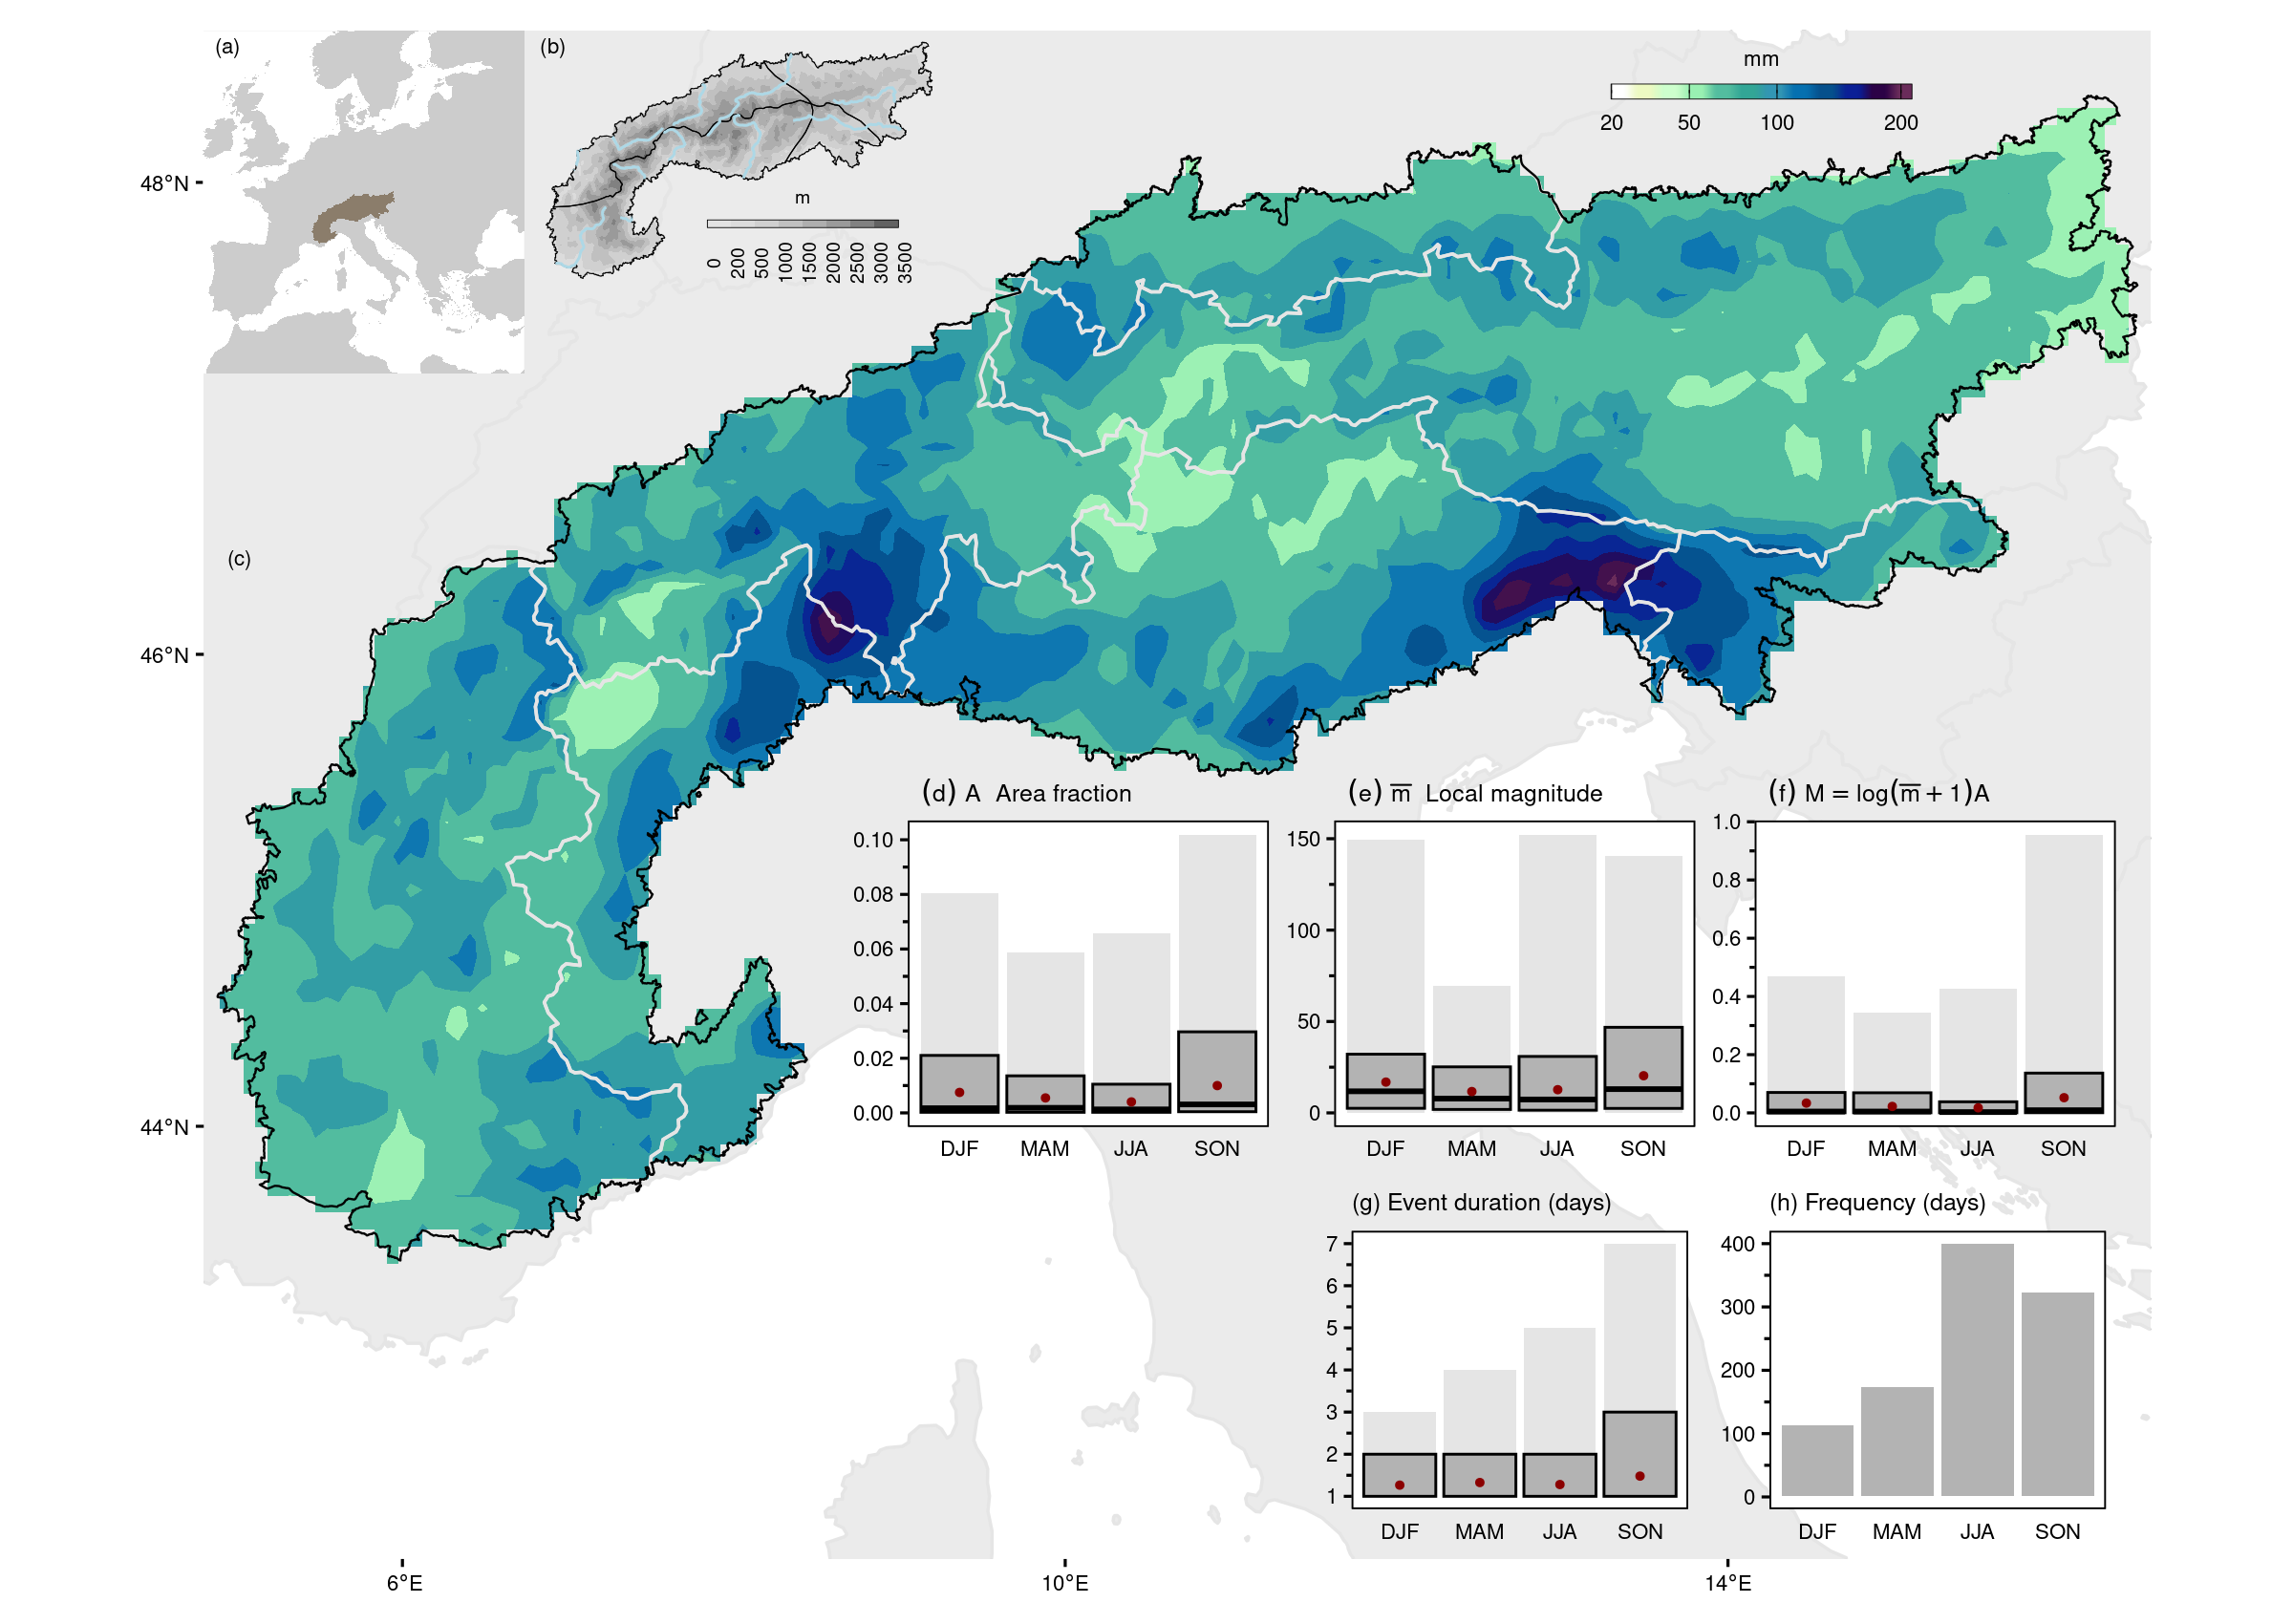

In [18]:
## ---- Compose final figure -------------------------------------------------
final_plot <- main +
  inset_element(context_plot, left = -0.04, bottom = 0.76, right = 0.20, top = 1.01) +
  inset_element(g1, left = 0.325, bottom = 0.25, right = 0.99, top = 0.53) +
  inset_element(g2g3, left = 0.568, bottom = 0.0, right = 0.985, top = 0.25) +
  inset_element(mdt_map, left = 0.15, bottom = 0.83, right = 0.40, top = 1)

options(repr.plot.width = 12, repr.plot.height = 8.5, repr.plot.res = 200)
final_plot
